### In this notebook we will check the assumption that stocastic gepth help deep network predict better than without it.

### In our experements we used ResNet-50 with bottleneck blocks: https://arxiv.org/abs/1512.03385

### Stochastic depth: https://arxiv.org/abs/1603.09382

Main idea in stochastic depth similar to [dropuot](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf), but now we drop all layer, instead some weights. 

In [1]:
import os
import sys

import time
import blosc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output

%matplotlib inline

sys.path.append('..')
import utils
from resnet_model import ResNetModel
from dataset import B,V,F
from dataset.dataset.opensets import MNIST

### Load data

In [2]:
dset = MNIST()

ExtractingExtractingExtractingExtracting   /tmp/t10k-labels-idx1-ubyte.gz /tmp/train-images-idx3-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz
/tmp/train-labels-idx1-ubyte.gz




### train models 

In [3]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1),
                                 'dtype': 'float32',
                                 'data_format': 'channels_last'},
                
                       'labels': {'shape': (10),
                                 'data_format': 'channels_last',
                                 'transform': 'ohe',
                                 'dtype': 'int32',
                                 'name': 'targets'}
                       }

In [4]:
Bottlenet_config = {'inputs': placeholders_config,
    'input': {
        'n_classes': 10,
        'dim': 2
             },
    'loss': 'softmax_cross_entropy',
    'optimizer': 'Adam',
    'bottleneck': True
} 
Stochastic_config = {**Bottlenet_config,
                     'stochastic': True}

In [5]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

In [13]:
bottle_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNetModel,
                      'bottle',
                      config=Bottlenet_config)
           .train_model('bottle',
                        feed_dict=placehold_dict))
bottle_te_ppl = (dset.test
           .p
           .init_variable('bottleacc', init_on_each_run=list)
           .import_model('bottle', bottle_tr_ppl)
           .predict_model('bottle',
                        fetches='accuracy',
                        feed_dict=placehold_dict,
                        save_to=V('bottleacc'), mode='a'))

In [14]:
stochastic_tr_ppl = (dset.train
                    .p
                    .init_model('dynamic',
                               ResNetModel,
                               'stochastic',
                               config=Stochastic_config)
                    .train_model('stochastic',
                                feed_dict=placehold_dict))
stochastic_te_ppl = (dset.test
                    .p
                    .init_variable('stochasticacc', init_on_each_run=list)
                    .import_model('stochastic', stochastic_tr_ppl)
                    .predict_model('stochastic',
                                  fetches='accuracy',
                                  feed_dict=placehold_dict,
                                  save_to=V('stochasticacc'), mode='a'))

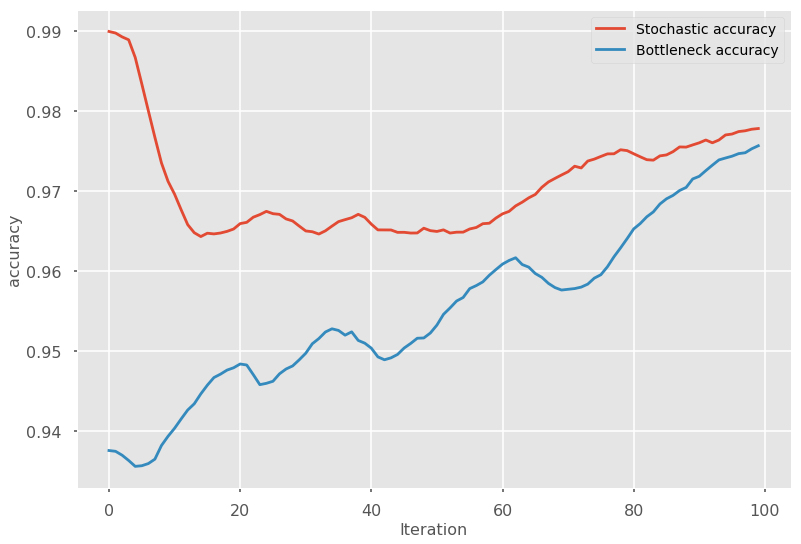

In [15]:
time_stochastic = 0
time_bottle = 0
for i in tqn(range(500)):
    batch = time.time()
    bottle_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    time_bottle +=time.time() - batch
    bottle_te_ppl.next_batch(400, n_epochs=None, shuffle=True)
    batch = time.time()
    stochastic_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    time_stochastic += time.time() - batch
    stochastic_te_ppl.next_batch(400, n_epochs=None, shuffle=True)
    if i%10==0 and i != 0:
        clear_output(True)
        Stochastic_loss = stochastic_te_ppl.get_variable('stochasticacc')
        Bottle_loss = bottle_te_ppl.get_variable('bottleacc')
        utils.draw(Stochastic_loss[-100:], 'Stochastic', Bottle_loss[-100:], 'Bottleneck', type_data='accuracy')
        plt.show()

In [16]:
time_stochastic, time_bottle

(362.26202034950256, 366.0632345676422)

../utils.py:48: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:49: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


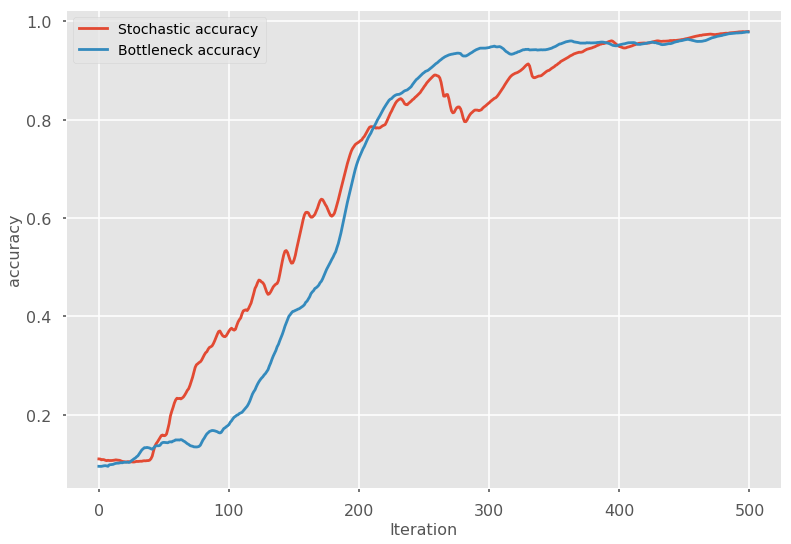

In [17]:
utils.draw(Stochastic_loss, 'Stochastic', Bottle_loss, 'Bottleneck', type_data='accuracy')

### Last 300 iteration

../utils.py:48: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:49: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


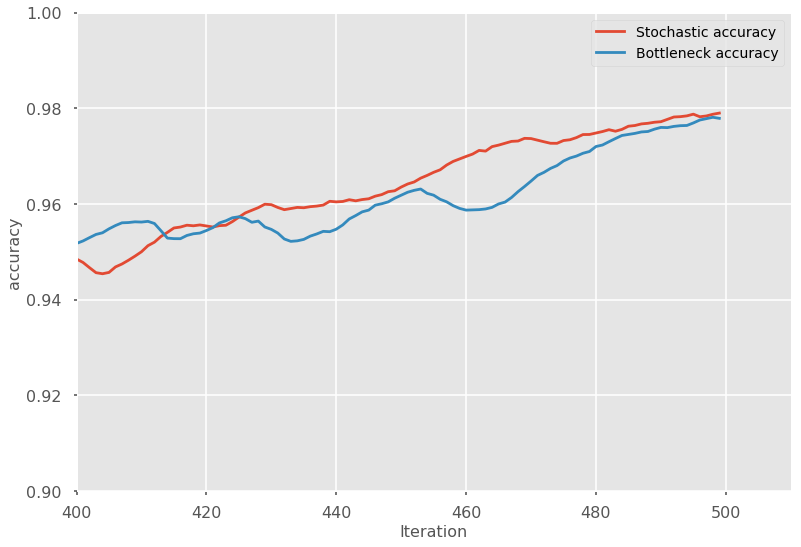

In [19]:
utils.draw(Stochastic_loss, 'Stochastic', Bottle_loss, 'Bottleneck', type_data='accuracy', bound=[400, 510, 0.9 , 1])

### The graphs show that stochastic model at the beginning loses simple model, but after 200 iteration, it catches up with the usual model for quality and sometimes even overtakes. 